In [1]:
import os

# to avoid the following error when using MPS (GPU in ARM architecture)):
# NotImplementedError: The operator 'aten::scatter_reduce.two_out'
# is not currently implemented for the MPS device. If you want
# this op to be added in priority during the prototype phase of
# this feature, please comment on
# https://github.com/pytorch/pytorch/issues/77764.
# As a temporary fix, you can set the environment variable
# `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as
# a fallback for this op.
# WARNING: this will be slower than running natively on MPS.
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # before importing torch

print(os.cpu_count())


8


\# TODO

- <s>BatchNormalization?</s>
- ハイパーパラメータチューニング (optuna?)
- <s>モデルの解釈 (tanhやpoolingについて)</s>
  - tanh: 活性化関数
  - pooling: すべての原子の情報を統合する。原子数が異なるためそれらを揃える役割も。
- <s>dropoutの導入？←過学習対策</s>
- autumentation?
- モデルの途中保存 (エポック毎?)
- エッジの重みも学習する (`nn.Parameter`?)
- early-stopping
- max-poolingの検討
- 転移学習 (fine-tuning and feature-extraction)
- [GIN層](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GINConv.html#torch_geometric.nn.conv.GINConv)を試してみる

In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

import torch
import torch.utils.data

import torch_geometric
import torch_geometric.nn
import torch_geometric.data
import torch_geometric.loader

import lightning
import lightning.pytorch.loggers
import lightning.pytorch.callbacks.early_stopping

from torch_utils.data import GraphDataset
from torch_utils.model import GCN
from torch_utils.torch_utils import (
    torch_seed,
)
from torch_utils.utils import yyplot
from torch_utils.lightning_utils import LightningGCN


In [3]:
torch.__version__


'2.1.0'

In [4]:
torch_geometric.__version__


'2.4.0'

In [5]:
rdkit.__version__


'2023.09.1'

In [6]:
seed = 334
batch_size = 64

torch_seed(seed)


In [7]:
# df_raw = pd.read_csv("./data/curated-solubility-dataset.csv", index_col=0)
df_raw = pd.read_csv("./data/logSdataset1290.csv", index_col=0)
# 計算時間短縮
# df_raw = df_raw.iloc[:1000]
print(df_raw.shape)
df_raw.head()


(1290, 197)


,logS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
CC(N)=O,1.58,59.068,54.028,59.037114,24,0,0.213790,-0.369921,0.369921,0.213790,...,0,0,0,0,0,0,0,0,0,0
CNN,1.34,46.073,40.025,46.053098,20,0,-0.001725,-0.271722,0.271722,0.001725,...,0,0,0,0,0,0,0,0,0,0
CC(=O)O,1.22,60.052,56.020,60.021129,24,0,0.299685,-0.481433,0.481433,0.299685,...,0,0,0,0,0,0,0,0,0,0
C1CCNC1,1.15,71.123,62.051,71.073499,30,0,-0.004845,-0.316731,0.316731,0.004845,...,0,0,0,0,0,0,0,0,0,0
NC(=O)NO,1.12,76.055,72.023,76.027277,30,0,0.335391,-0.349891,0.349891,0.335391,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# smiles = df_raw["SMILES"]
# y = df_raw["Solubility"]
smiles = df_raw.index
y = df_raw["logS"]


In [9]:
# scaling
y_mean = y.mean()
y_std = y.std(ddof=1)


In [10]:
smiles = smiles.tolist()
y = torch.Tensor(((y - y_mean) / y_std).tolist()).view(-1, 1)


In [11]:
mols = map(Chem.MolFromSmiles, smiles)


In [12]:
dataset = GraphDataset(mols, y, n_jobs=-1, ipynb=True)
dataset


  0%|          | 0/1290 [00:00<?, ?it/s]

GraphDataset(size=1290)

In [13]:
dataset_train, dataset_test, dataset_val = torch.utils.data.random_split(
    dataset, [0.75, 0.10, 0.15], torch.Generator().manual_seed(seed)
)
print(len(dataset_train), len(dataset_val), len(dataset_test))


968 193 129


In [14]:
dataloader_train = torch_geometric.loader.DataLoader(
    dataset_train,
    batch_size=batch_size,
    # The 'train_dataloader' does not have many workers which may be a bottleneck.
    # Consider increasing the value of the `num_workers` argument` to `num_workers=7`
    # in the `DataLoader` to improve performance.
    num_workers=os.cpu_count(),
    # Consider setting `persistent_workers=True` in 'train_dataloader'
    # to speed up the dataloader worker initialization.
    persistent_workers=True,
    sampler=torch.utils.data.RandomSampler(
        dataset_train, generator=torch.Generator().manual_seed(seed)
    ),
)
dataloader_val = torch_geometric.loader.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count(),
    persistent_workers=True,
)
dataloader_test = torch_geometric.loader.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count(),
)


In [15]:
data = dataset_train[0]
num_features = data.x.shape[1]


In [16]:
model = GCN(in_channels=num_features, embedding_size=64)
print(model)


GCN(
  (initial_conv): GCNConv(30, 64)
  (batch_norm0): BatchNorm(64)
  (conv1): GCNConv(64, 64)
  (batch_norm1): BatchNorm(64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dropout): Dropout(p=0.05, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [17]:
# Need 'tabulate' package
print(torch_geometric.nn.summary(model, data))


+----------------------------+---------------+----------------+----------+
| Layer                      | Input Shape   | Output Shape   | #Param   |
|----------------------------+---------------+----------------+----------|
| GCN                        | [28, 28]      | [1, 1]         | 14,849   |
| ├─(initial_conv)GCNConv    |               | [28, 64]       | 1,984    |
| ├─(batch_norm0)BatchNorm   | [28, 64]      | [28, 64]       | 128      |
| │    └─(module)BatchNorm1d | [28, 64]      | [28, 64]       | 128      |
| ├─(conv1)GCNConv           |               | [28, 64]       | 4,160    |
| ├─(batch_norm1)BatchNorm   | [28, 64]      | [28, 64]       | 128      |
| │    └─(module)BatchNorm1d | [28, 64]      | [28, 64]       | 128      |
| ├─(conv2)GCNConv           |               | [28, 64]       | 4,160    |
| ├─(conv3)GCNConv           |               | [28, 64]       | 4,160    |
| ├─(dropout)Dropout         | [28, 64]      | [28, 64]       | --       |
| ├─(relu)LeakyReLU      

In [18]:
model_lightning = LightningGCN(
    model,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=torch.nn.MSELoss(),
)


In [19]:
early_stopping = lightning.pytorch.callbacks.early_stopping.EarlyStopping(
    monitor="val_loss", patience=5, min_delta=0, mode="min"
)


In [20]:
# The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50).
# Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
trainer = lightning.Trainer(
    accelerator="auto",
    max_epochs=100,
    callbacks=[early_stopping],
    logger=(
        lightning.pytorch.loggers.TensorBoardLogger(
            save_dir="logs", name="gcn_tb"
        ),
        lightning.pytorch.loggers.CSVLogger(save_dir="logs", name="gcn_csv"),
    ),
    log_every_n_steps=16,
)
trainer.fit(model_lightning, dataloader_train, dataloader_val)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params
--------------------------------------
0 | net       | GCN     | 14.8 K
1 | criterion | MSELoss | 0     
--------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yu9824/miniforge3/envs/torch39/lib/python3.9/site-packages/torch_geometric/utils/scatter.py:94: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
trainer.test(model_lightning, dataloader_test)


/Users/yu9824/miniforge3/envs/torch39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.18864604830741882    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.18864604830741882}]

In [22]:
dataloader_train_for_predict = torch_geometric.loader.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count(),
    persistent_workers=True,
)


In [23]:
y_train_scaled = torch.cat(
    [_databatch.y for _databatch in dataloader_train_for_predict], dim=0
)
y_pred_train_scaled: torch.Tensor = torch.cat(
    trainer.predict(model_lightning, dataloader_train_for_predict), dim=0
)
y_pred_train_scaled.shape


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([968, 1])

In [24]:
y_val_scaled = torch.cat(
    [_databatch.y for _databatch in dataloader_val], dim=0
)
y_pred_val_scaled: torch.Tensor = torch.cat(
    trainer.predict(model_lightning, dataloader_val), dim=0
)
y_pred_val_scaled.shape


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([193, 1])

In [25]:
y_test_scaled = torch.cat(
    [_databatch.y for _databatch in dataloader_test], dim=0
)
y_pred_test_scaled: torch.Tensor = torch.cat(
    trainer.predict(model_lightning, dataloader_test), dim=0
)
y_pred_test_scaled.shape


/Users/yu9824/miniforge3/envs/torch39/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([129, 1])

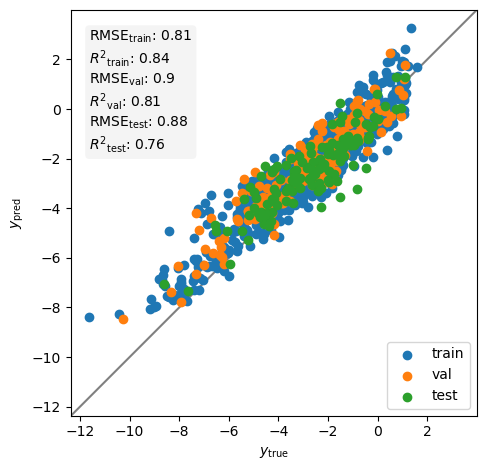

In [26]:
ax = yyplot(
    y_train_scaled * y_std + y_mean,
    y_pred_train_scaled * y_std + y_mean,
    y_val_scaled * y_std + y_mean,
    y_pred_val_scaled * y_std + y_mean,
    y_test_scaled * y_std + y_mean,
    y_pred_test_scaled * y_std + y_mean,
)


In [27]:
df_history = pd.read_csv(
    os.path.join(trainer.loggers[1].log_dir, "metrics.csv")
)
df_history.head()


,epoch,step,val_loss,train_loss,test_loss
0,0,15,0.935841,NaN,NaN
1,0,15,NaN,0.854927,NaN
2,1,31,0.583050,NaN,NaN
3,1,31,NaN,0.485611,NaN
4,2,47,0.284904,NaN,NaN


In [28]:
df_history = df_history.groupby("epoch").mean().reset_index()
df_history.head()


,epoch,step,val_loss,train_loss,test_loss
0,0,15.0,0.935841,0.854927,NaN
1,1,31.0,0.583050,0.485611,NaN
2,2,47.0,0.284904,0.322372,NaN
3,3,63.0,0.190120,0.260752,NaN
4,4,79.0,0.197103,0.243483,NaN


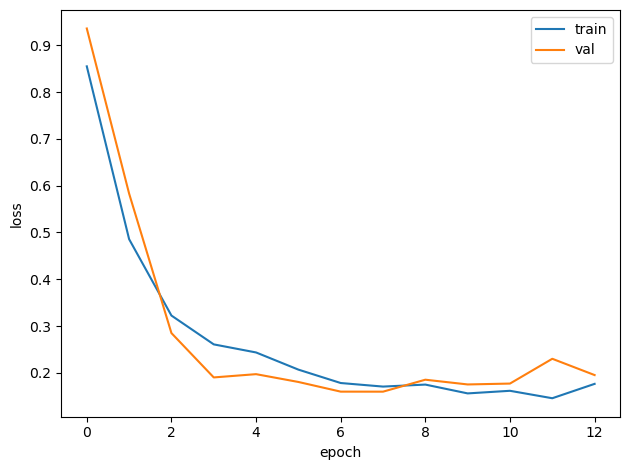

In [29]:
fig, ax = plt.subplots(facecolor="w")
ax.plot(df_history["epoch"], df_history["train_loss"], label="train")
ax.plot(df_history["epoch"], df_history["val_loss"], label="val")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
fig.tight_layout()
